In [1]:
import numpy as np
import pandas as pd
import wfdb
import os
import scipy.signal as sgn
from tqdm import tqdm
from keras import models, layers, optimizers, regularizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from scipy.signal import cheby1, filtfilt

In [2]:
# File paths
train_files = [f"a{str(i).zfill(2)}" for i in range(1, 21)] + [f"b{str(i).zfill(2)}" for i in range(1, 6)] + [f"c{str(i).zfill(2)}" for i in range(1, 11)]
test_files = [f"x{str(i).zfill(2)}" for i in range(1, 36)]
base_path = ""
train_paths = [os.path.join(base_path, file) for file in train_files]
test_paths = [os.path.join(base_path, file) for file in test_files]


In [3]:
# Data augmentation functions
def add_noise(signal, noise_factor=0.005):
    noise = np.random.randn(len(signal)) * noise_factor
    return signal + noise

def scale(signal, scaling_factor=0.1):
    scale = np.random.uniform(1 - scaling_factor, 1 + scaling_factor)
    return signal * scale

def time_shift(signal, shift_max=50):
    shift = np.random.randint(-shift_max, shift_max)
    if shift > 0:
        return np.r_[signal[shift:], np.zeros(shift)]
    else:
        return np.r_[np.zeros(-shift), signal[:shift]]

def flip(signal):
    return -signal

def random_dropout(signal, drop_factor=0.1):
    drop_indices = np.random.choice(len(signal), int(len(signal) * drop_factor), replace=False)
    signal_copy = signal.copy()
    signal_copy[drop_indices] = 0
    return signal_copy


# Preprocessing function
def apply_chebyshev_filter(signal, lowcut=0.5, highcut=40, fs=100, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = cheby1(order, 0.5, [low, high], btype='band')
    return filtfilt(b, a, signal)

def load_ecg_and_segment(file, segment_duration=10, fs=100):
    record = wfdb.rdrecord(file)
    annotation = wfdb.rdann(file, 'apn')
    signal = record.p_signal[:, 0]
    filtered_signal = apply_chebyshev_filter(signal)
    segments, labels = [], []
    samples_per_segment = segment_duration * fs

    for i, samp in enumerate(annotation.sample):
        start = max(samp - samples_per_segment // 2, 0)
        end = start + samples_per_segment
        if end > len(filtered_signal):
            break
        segment = filtered_signal[start:end]
        segments.append(segment)
        labels.append(1 if annotation.symbol[i] == 'A' else 0)
        
    return np.array(segments), np.array(labels)

# Adjust augment_data to ensure consistent segment length
def augment_data(signal, segment_length=1000):
    augmentations = [add_noise, scale, time_shift, flip, random_dropout]
    augmented_signals = []
    for aug in augmentations:
        augmented_signal = aug(signal)
        # Ensure each augmented signal has the same length
        if len(augmented_signal) > segment_length:
            augmented_signal = augmented_signal[:segment_length]
        elif len(augmented_signal) < segment_length:
            augmented_signal = np.pad(augmented_signal, (0, segment_length - len(augmented_signal)), 'constant')
        augmented_signals.append(augmented_signal)
    return augmented_signals

# Modify prepare_data_with_augmentation to ensure consistent segment length
def prepare_data_with_augmentation(paths, segment_length=1000, augment=True):
    X, y = [], []
    for path in tqdm(paths):
        segments, seg_labels = load_ecg_and_segment(path)
        for i, segment in enumerate(segments):
            # Ensure each original segment has the desired length
            if len(segment) < segment_length:
                segment = np.pad(segment, (0, segment_length - len(segment)), 'constant')
            X.append(segment)
            y.append(seg_labels[i])
            
            # Augment if specified
            if augment:
                augmented_segments = augment_data(segment, segment_length=segment_length)
                X.extend(augmented_segments)
                y.extend([seg_labels[i]] * len(augmented_segments))  

    return np.array(X), np.array(y)


In [4]:
from sklearn.utils import shuffle

# Load and augment training data
X_train, y_train = prepare_data_with_augmentation(train_paths, segment_length=1000, augment=True)
X_test, y_test = prepare_data_with_augmentation(test_paths, segment_length=1000, augment=False)


# Shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Print the number of segments loaded for verification
print(f"Training segments: {len(X_train)}, Test segments: {len(X_test)}")

# Reshape data for model input format
X_train = X_train[..., np.newaxis]  # Adding channel dimension
X_test = X_test[..., np.newaxis]

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:08<00:00,  4.35it/s]


Training segments: 102270, Test segments: 17268
Training data shape: (102270, 1000, 1)
Training labels shape: (102270,)
Test data shape: (17268, 1000, 1)
Test labels shape: (17268,)


In [5]:
print(y_train[0])

1


In [6]:
from sklearn.model_selection import StratifiedKFold

# Splitting the training data into train and validation sets with StratifiedKFold
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_indices, val_indices = next(strat_kfold.split(X_train, y_train))

# Creating training and validation sets
X_ctrain, X_val = X_train[train_indices], X_train[val_indices]
y_ctrain, y_val = y_train[train_indices], y_train[val_indices]

# Print shapes of the resulting sets for verification
print("Train data shape:", X_ctrain.shape)
print("Validation data shape:", X_val.shape)
print("Train labels shape:", y_ctrain.shape)
print("Validation labels shape:", y_val.shape)

Train data shape: (81816, 1000, 1)
Validation data shape: (20454, 1000, 1)
Train labels shape: (81816,)
Validation labels shape: (20454,)


In [7]:
# Build CNN-LSTM Model
def build_cnn_lstm_model(input_shape):
    input_layer = layers.Input(shape=input_shape)
    x_bn = layers.BatchNormalization()(input_layer)
    
    branch1 = layers.Conv1D(24, kernel_size=125, strides=1, activation='relu', padding='same')(x_bn)
    branch1 = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(branch1)
    
    branch2 = layers.Conv1D(24, kernel_size=15, strides=1, activation='relu', padding='same')(x_bn)
    branch2 = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(branch2)
    
    branch3 = layers.Conv1D(24, kernel_size=5, strides=1, activation='relu', padding='same')(x_bn)
    branch3 = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(branch3)
    
    concatenated = layers.Concatenate(axis=-1)([branch1, branch2, branch3])
    x = layers.MaxPooling1D(pool_size=3, strides=1, padding='same')(concatenated)
    
    conv_adjusted = layers.Conv1D(24, kernel_size=3, strides=1, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(conv_adjusted)
    x = layers.Add()([x, conv_adjusted])
    
    x = layers.Dense(48, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Reshape((1, -1))(x)
    x = layers.LSTM(64)(x)
    
    output_layer = layers.Dense(2, activation='softmax')(x)
    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model


In [8]:

from sklearn.metrics import confusion_matrix, cohen_kappa_score
from tensorflow.keras.callbacks import Callback
# Define KappaCallback with validation data
class KappaCallback(Callback):
    def __init__(self, validation_data):
        super(KappaCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = np.argmax(self.model.predict(X_val), axis=1)
        kappa = cohen_kappa_score(y_val, y_pred)
        logs['kappa'] = kappa
        print(f'Epoch {epoch+1} - Kappa: {kappa:.4f}')

# Training setup
input_shape = (1000, 1)
batch_size = 64
epochs = 50
learning_rate = 0.001

# Compile the model
model = build_cnn_lstm_model(input_shape)
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1000, 1)]            0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 1000, 1)              4         ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv1d (Conv1D)             (None, 1000, 24)             3024      ['batch_normalization[0][0]'] 
                                                                                                  
 conv1d_1 (Conv1D)           (None, 1000, 24)             384       ['batch_normalization[0]

In [ ]:
# Define the model checkpoint
checkpoint_path = ""
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model with KappaCallback
kappa_callback = KappaCallback(validation_data=(X_val, y_val))
history = model.fit(
    X_ctrain, y_ctrain,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr, kappa_callback,checkpoint
              ],
    verbose=1
)

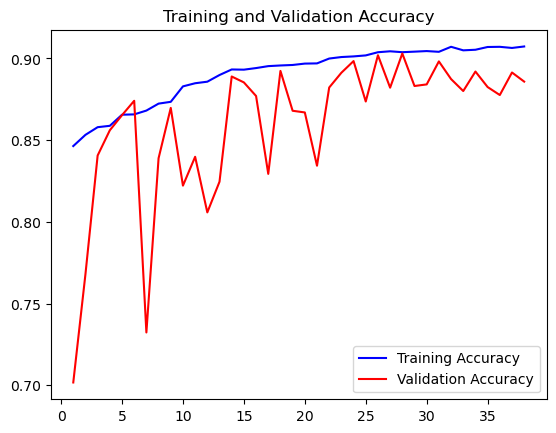

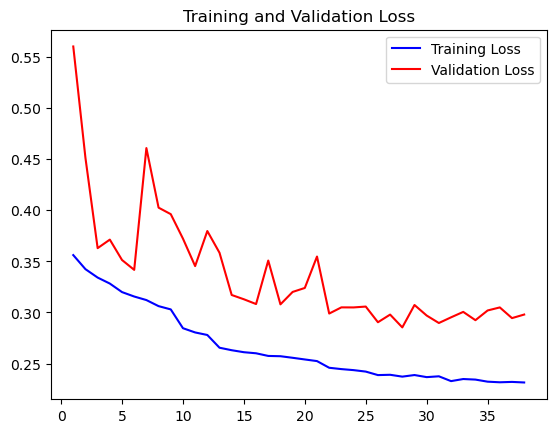

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure()
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# Reload the model from the checkpoint
checkpoint_path = "C:/Users/abbas/BAU/11Fall 2024/FYP2/apnea-ecg/1.0.0/Model_CheckPoint_draft_3/best_model.keras"
model = load_model(checkpoint_path, custom_objects={'KappaCallback': KappaCallback})

# Optional: reinitialize callbacks if needed
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
kappa_callback = KappaCallback(validation_data=(X_val, y_val))

# Continue training the model
history = model.fit(
    X_ctrain, y_ctrain,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=50,  # Define how many more epochs you want to train
    callbacks=[early_stopping, reduce_lr, kappa_callback, checkpoint],
    verbose=1
)


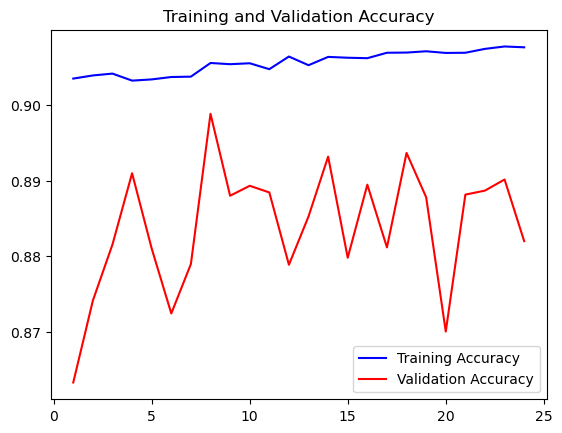

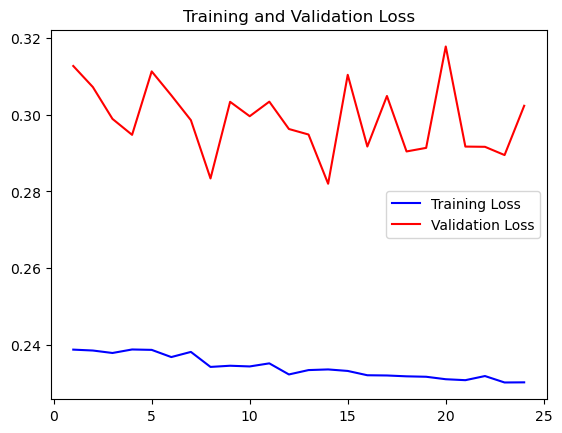

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure()
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [12]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict on the test set
y_test_pred = np.argmax(model.predict(X_test), axis=1)

# Compute confusion matrix and evaluation metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
TAC = (tp + tn) / (tp + tn + fp + fn) * 100
sensitivity = tp / (tp + fn) * 100
specificity = tn / (tn + fp) * 100
PPV = tp / (tp + fp) * 100
NPV = tn / (tn + fn) * 100
kappa = cohen_kappa_score(y_test, y_test_pred)

# Display metrics
print(f"Total Accuracy (TAC): {TAC:.2f}%")
print(f"Sensitivity (SE): {sensitivity:.2f}%")
print(f"Specificity (SP): {specificity:.2f}%")
print(f"Positive Predictive Value (PPV): {PPV:.2f}%")
print(f"Negative Predictive Value (NPV): {NPV:.2f}%")
print(f"Cohen's Kappa Score: {kappa:.2f}")

Test Accuracy: 71.47%
540/540 [==============================] - 12s 23ms/step
Total Accuracy (TAC): 71.47%
Sensitivity (SE): 53.01%
Specificity (SP): 82.76%
Positive Predictive Value (PPV): 65.26%
Negative Predictive Value (NPV): 74.24%
Cohen's Kappa Score: 0.37
